In [32]:
import utils
import classes
import h5py
  
from keras.layers import *
from keras import Model
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
from keras import regularizers
import numpy as np
import keras, time
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
bg_momenta,bg_labels=utils.loadJetMomentaBenchmark("background.h5",nConstituents=40)

Loading indices from None to 100000

Mean label
0.0



In [4]:
bg_dataset= h5py.File("bg_dataset.h5", "w")

In [5]:
bg_dataset.create_dataset('momenta', data=bg_momenta)
bg_dataset.create_dataset('labels', data=bg_labels)

<HDF5 dataset "labels": shape (100000, 2), type "<f4">

In [6]:
sig_momenta,sig_labels=utils.loadJetMomentaBenchmark("signal.h5",nConstituents=40)
sig_dataset= h5py.File("sig_dataset.h5", "w")

Loading indices from None to 100000

Mean label
1.0



In [7]:
sig_dataset.create_dataset('momenta', data=sig_momenta)
sig_dataset.create_dataset('labels', data=sig_labels)

<HDF5 dataset "labels": shape (100000, 2), type "<f4">

In [8]:

def loadData(filenames, nJets=slice(200000), nConstituents=40):
    with h5py.File(filenames[0], 'r') as f:
        bg_momenta = f['momenta'][nJets, :nConstituents, :]
        bg_labels = np.zeros(len(bg_momenta))
    
    with h5py.File(filenames[1], 'r') as f:
        sig_momenta = f['momenta'][nJets, :nConstituents, :]
        sig_labels = np.ones(len(sig_momenta))

    momenta = np.append(bg_momenta, sig_momenta, axis=0)

    labels = keras.utils.to_categorical(
            np.append(bg_labels, sig_labels), 2)
    indices = np.random.permutation(len(labels))
    print(momenta.shape, labels.shape)
    return momenta[indices], labels[indices]


In [41]:
vectors, labels = loadData(
                filenames = ["bg_dataset.h5", "sig_dataset.h5"]
                )

(200000, 4, 40) (200000, 2)


In [10]:
    model = classes.LoLaClassifier(nConstituents=40, nAdded=10).model


In [11]:
    model.compile(
            optimizer=keras.optimizers.Adam(lr=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['acc'])


In [12]:
    print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 40)             0         
_________________________________________________________________
cola (CoLa)                  (None, 4, 50)             400       
_________________________________________________________________
lola (LoLa)                  (None, 7, 50)             2704      
_________________________________________________________________
flatten_1 (Flatten)          (None, 350)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               35100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510 

In [13]:
model111 = model.fit(vectors, labels,
        verbose=2,
        batch_size=512,
        validation_split=0.1,
        epochs=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 180000 samples, validate on 20000 samples
Epoch 1/100
 - 7s - loss: 3.2457 - acc: 0.7717 - val_loss: 0.6420 - val_acc: 0.7990
Epoch 2/100
 - 7s - loss: 0.5239 - acc: 0.8241 - val_loss: 0.4687 - val_acc: 0.8429
Epoch 3/100
 - 7s - loss: 0.4482 - acc: 0.8499 - val_loss: 0.4361 - val_acc: 0.8551
Epoch 4/100
 - 7s - loss: 0.4261 - acc: 0.8578 - val_loss: 0.4203 - val_acc: 0.8698
Epoch 5/100
 - 10s - loss: 0.4118 - acc: 0.8651 - val_loss: 0.4051 - val_acc: 0.8669
Epoch 6/100
 - 10s - loss: 0.3996 - acc: 0.8668 - val_loss: 0.3917 - val_acc: 0.8708
Epoch 7/100
 - 9s - loss: 0.3880 - acc: 0.8715 - val_loss: 0.3809 - val_acc: 0.8763
Epoch 8/100
 - 9s - loss: 0.3766 - acc: 0.8745 - val_loss: 0.3711 - val_acc: 0.8799
Epoch 9/100
 - 9s - loss: 0.3665 - acc: 0.8768 - val_loss: 0.3603 - val_acc: 0.8828
Epoch 10/100
 - 8s - loss: 0.3569 - acc: 0.8801 - val_loss: 0.3552 - val_acc: 0.8899
Epoch 11/10

Epoch 91/100
 - 7s - loss: 0.1858 - acc: 0.9217 - val_loss: 0.2199 - val_acc: 0.9124
Epoch 92/100
 - 7s - loss: 0.1851 - acc: 0.9222 - val_loss: 0.2232 - val_acc: 0.9123
Epoch 93/100
 - 7s - loss: 0.1847 - acc: 0.9231 - val_loss: 0.2202 - val_acc: 0.9115
Epoch 94/100
 - 7s - loss: 0.1850 - acc: 0.9225 - val_loss: 0.2234 - val_acc: 0.9140
Epoch 95/100
 - 7s - loss: 0.1844 - acc: 0.9228 - val_loss: 0.2224 - val_acc: 0.9135
Epoch 96/100
 - 7s - loss: 0.1842 - acc: 0.9233 - val_loss: 0.2267 - val_acc: 0.9080
Epoch 97/100
 - 7s - loss: 0.1837 - acc: 0.9233 - val_loss: 0.2248 - val_acc: 0.9120
Epoch 98/100
 - 7s - loss: 0.1832 - acc: 0.9234 - val_loss: 0.2225 - val_acc: 0.9129
Epoch 99/100
 - 7s - loss: 0.1829 - acc: 0.9236 - val_loss: 0.2267 - val_acc: 0.9122
Epoch 100/100
 - 7s - loss: 0.1825 - acc: 0.9236 - val_loss: 0.2251 - val_acc: 0.9125


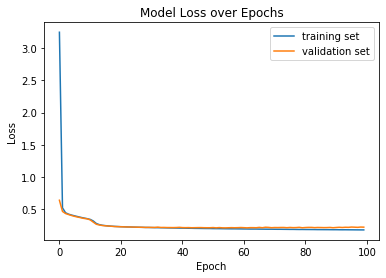

In [14]:

plt.figure()
plt.plot(model111.history['loss'])
plt.plot(model111.history['val_loss'])
plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training set','validation set'])
plt.show()

In [44]:
def makeRoc(features_val, labels, labels_val, model):
    print('in makeRoc()')
    if 'j_index' in labels: labels.remove('j_index')

    predict_test = model.predict(features_val)

    df = pd.DataFrame()
    
    fpr = {}
    tpr = {}
    auc1 = {}
    
    plt.figure()       
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = predict_test[:,i]
        
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
            
        plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.semilogy()
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig("mygraph.png")
#     plt.savefig('%s/ROC.pdf'%(options.outputDir))
#     plt.savefig('%s/ROC.pdf' %(outputDir))
    return predict_test

In [34]:

def loadJetMomenta(filenames, nJets=slice(200000), nConstituents=40):
    """Load jet momenta from given files
    Input:
     filenames: (2,) - list containing path to bg and sig jet momenta
     nJets: slice - indices for loading data
     nConstituents: int giving number of leading pT constituents per jet
    Returns:
     momenta: (nJets, 4, nConstituents) shuffled array of jet momenta
     labels: (nJets, 2) one hot encoded labels for momenta
    """
    print("Loading by given slice {}".format(nJets))
    # Load momenta from bg_file
    with h5py.File(filenames[0], 'r') as f:
        if f['momenta'].shape[-1] == 4:
            bg_momenta = f['momenta'][nJets, :nConstituents, :]
        elif f['momenta'].shape[-2] == 4:
            bg_momenta = f['momenta'][nJets, :, :nConstituents]
        else:
            print("Momenta cannot be loaded")
            exit()
        bg_labels = np.zeros(len(bg_momenta))
        print("\n{} bg jets loaded from {}".format(
            len(bg_labels), filenames[0]))

    # Load momenta from sig_file
    with h5py.File(filenames[1], 'r') as f:
        if f['momenta'].shape[-1] == 4:
            sig_momenta = f['momenta'][nJets, :nConstituents, :]
        elif f['momenta'].shape[-2] == 4:
            sig_momenta = f['momenta'][nJets, :, :nConstituents]
        else:
            print("Momenta cannot be loaded")
            exit()
            
        sig_labels = np.ones(len(sig_momenta))
        print("{} sig jets loaded from {}\n\n".format(
            len(sig_labels), filenames[1]))


    # Connect momenta, shuffle and return them with corresponding labels
    momenta = np.append(bg_momenta, sig_momenta, axis=0)
    labels = keras.utils.to_categorical(
            np.append(bg_labels, sig_labels), 2)
    indices = np.random.permutation(len(labels))
    print(momenta.shape, labels.shape)
    return momenta[indices], labels[indices]

In [45]:
momenta,labels1 = loadJetMomenta(["bg_dataset.h5","sig_dataset.h5"])

Loading by given slice slice(None, 200000, None)

100000 bg jets loaded from bg_dataset.h5
100000 sig jets loaded from sig_dataset.h5


(200000, 4, 40) (200000, 2)


In [49]:
import pandas as pd
makeRoc(vectors,labels,labels, model)

in makeRoc()


D:\Users\Azure\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


KeyError: "None of [Float64Index([0.0, 1.0], dtype='float64')] are in the [columns]"

<Figure size 432x288 with 0 Axes>